In [24]:
%matplotlib inline

# General libraries
import pandas as pd
import numpy as np
import os
import copy
import warnings
import statsmodels.api as sm
from scipy import stats

# Plotting and printing libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pprint
# from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
from matplotlib.figure import figaspect


# Model-building libraries
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import normalize, MinMaxScaler, StandardScaler, RobustScaler, Normalizer, scale

# SK-learn libraries for learning
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC, LinearSVC

# SK-learn libraries for evaluation
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics

In [3]:
label_names = {'1':'Spruce/Fir', 
               '2':'Lodgepole Pine', 
               '3':'Ponderosa Pine', 
               '4':'Cottonwood/Willow', 
               '5':'Aspen',
               '6':'Douglas Fir',
               '7':'Krummholz'}

In [ ]:
def apply_scaler(scaler, data):
    scaled_data = scaler.fit_transform(data)
    # Quick look to see if it behaved as expected
    scaled_df = pd.DataFrame(data=scaled_data,    # values
                         columns=data.columns)  # 1st row as the column names
    return scaled_df

In [4]:
def cross_validate_model(model, X, y, name="model", folds=5, verbose=False):
    '''Takes an sklearn or similar model, an X feature set, and a y label set.  
    It performs crossvalidation across n folds and prints the results.'''
    with warnings.catch_warnings(record=False):
        np.random.seed(10)

        reportFields = {'precision': [], 'recall': [], 'f1-score': []}
        generalReport = {'micro avg': copy.deepcopy(reportFields), 
                         'macro avg': copy.deepcopy(reportFields), 
                         'weighted avg':copy.deepcopy(reportFields)}
        for key in label_names:
            generalReport[key] = copy.deepcopy(reportFields)

        skf = StratifiedKFold(n_splits=folds, shuffle=True)
        for train_indexes, valid_indexes in skf.split(X, y):
            foldXTrain, foldYTrain = X.iloc[train_indexes], y.iloc[train_indexes]
            foldXValid, foldYValid = X.iloc[valid_indexes], y.iloc[valid_indexes] 

            model.fit(foldXTrain, foldYTrain)
            foldValidPred = model.predict(foldXValid)
            foldReport = metrics.classification_report(foldValidPred, foldYValid, output_dict=True)

            for key in foldReport:
                for outputField in reportFields:
                    generalReport[key][outputField].append(foldReport[key][outputField])
        title = f'Model: {name}'
        if verbose: title += f', with {folds} folds' 
        print(title)

        fields = sorted(generalReport.keys()) if verbose else ['weighted avg']
        fieldLabels = [label_names[field] if field in label_names.keys() else field for field in fields]

        for i in range(len(fields)):
            output = f'\t\t{fieldLabels[i]:<20} | '
            for outputField in reportFields:
                output += f'{outputField}: {np.mean(generalReport[fields[i]][outputField]):>5.2f} | '
            print(output)
        if verbose: print()

In [ ]:
def test_model(model, X_train, y_train, X_test, y_test, name="model", verbose=False):
    with warnings.catch_warnings(record=False):
        model.fit(X_train, y_train)
        testPrediction = model.predict(X_test)
        testReport = metrics.classification_report(testPrediction, y_test, output_dict=True)

        print(f'Model: {name}')
        reportFields = ['precision', 'recall', 'f1-score']
        fields = sorted(testReport.keys()) if verbose else ['weighted avg']
        fieldLabels = [label_names[field] if field in label_names.keys() else field for field in fields]
        fieldLabels[-1] = "Final"
        for i in range(len(fields)):
            output = f'\t\t{fieldLabels[i]:<20} | '
            for outputField in reportFields:
                output += f'{outputField}: {np.mean(testReport[fields[i]][outputField]):>5.2f} | '
            print(output)
        if verbose: print()
    

In [40]:
def show_photos(list_of_files, multiplier):
    w, h = figaspect(0.5) * multiplier
    file_ct = len(list_of_files)
    fig = plt.figure(figsize=(w,h))
    for i in range(file_ct):
        a = fig.add_subplot(1, file_ct, i + 1)
        image = imread(list_of_files[i])
        plt.imshow(image)
        plt.axis('off')

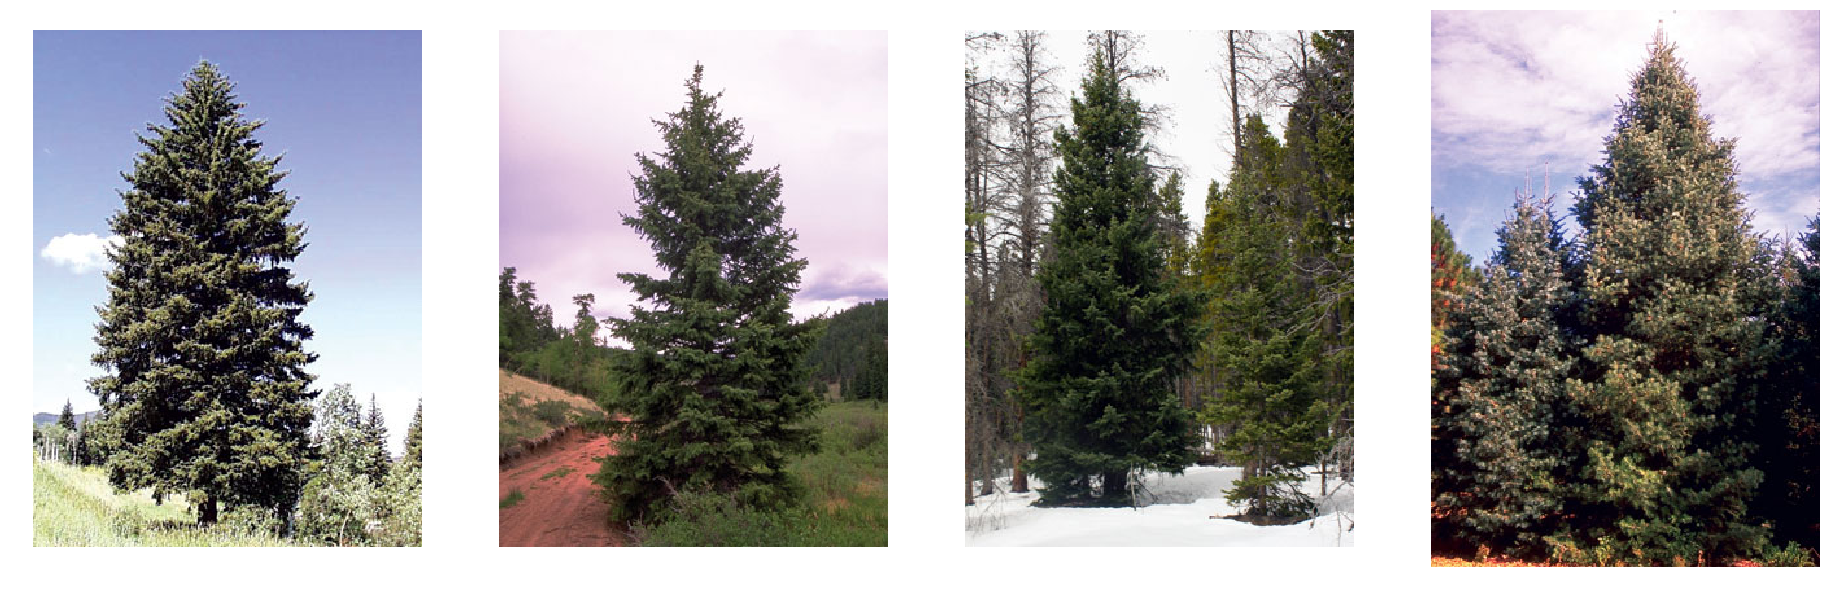

In [39]:
# show_photos(list_of_files = ['imgs/1_blue-spruce-tree.jpg',
#                  'imgs/1_engelmann-spruce.jpg',
#                 'imgs/1_subalpine-fir.jpg',
#                 'imgs/1_white-fir-tree.jpg'], multiplier=4)